# Special case: gaseous species
In this short special case tutorial we will discuss how to handle gaseous molecules such as $CO_2$, $O_2$ or other gaseous compounds either produced or consumed. 

First, we will setup the environment and load the testing dataset.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas, preprocess_gaseous_species
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
# fedbatch_df = load_standard_fedbatch()
fedbatch_df = _prepare_simulated_dataset("../../../article/data/standard_fed-batch_process.csv")

Species that evaporate from the reactor is a bit more complicated to transform. The method that we present here assumes that the mass of the species in aqueous solution is neglectable compared to the mass of species that evaporates or is consumed by the organism. This is typically the case for CO2 or O2.

To pseudo batch transform a gaseous product or substrate you need to pre-process the measurements of the gaseous compound. The pseudobatch package presents a function called `preprocess_gaseous_species()`. This function calculates a hypothetical concentration of the gaseous species in the reactor volume and accounts for sample withdrawal of this hypothetical concentration. The function is meant to transform data coming from an off-gas analyzer and uses the accumulated amount of gaseous species either produced or consumed.

The test dataset contain simulated the accumulated $CO_2$ production measurements in mass units in the column `m_CO2_gas`. Further, we se that the concentration of CO2 in the liquid phase is zero at all times. This is because in the simulation we assume that CO2 evaporated immediately after production.

array([[<Axes: xlabel='timestamp'>],
       [<Axes: xlabel='timestamp'>]], dtype=object)

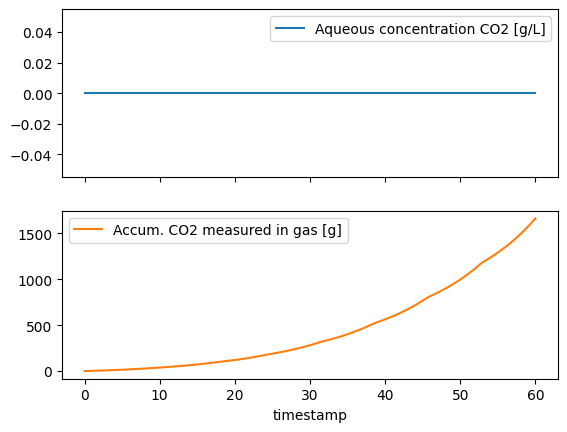

In [3]:
fedbatch_df.plot(x='timestamp', y=['c_CO2', 'm_CO2_gas'], subplots=True, layout=(2,1), label=['Aqueous concentration CO2 [g/L]', 'Accum. CO2 measured in gas [g]'])

Notice, how the production rate of CO2 (g/h) decrease the bioreactor is sampled. This is because the total amount of biomass decrease after sampling, thus there is less biomass to produce CO2. We will now use the `preprocess_gaseous_species()` to prepare the data for pseudo batch transformation.

In [4]:
fedbatch_df['preprocessed_c_CO2'] = preprocess_gaseous_species(
    accumulated_amount_of_gaseous_species=fedbatch_df['m_CO2_gas'].values,
    reactor_volume=fedbatch_df['v_Volume'].values,
    sample_volume=fedbatch_df['sample_volume'].values
)

Now, we can transform the preprocessed CO2 data and the biomass concentration measurements.

In [5]:
fedbatch_df[['pseudo_Biomass', 'pseudo_CO2']] = pseudobatch_transform_pandas(
    df=fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "preprocessed_c_CO2"],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname='v_Feed_accum',
    concentration_in_feed=[0,0],
    sample_volume_colname='sample_volume'
)

If we estimate the CO2 yield using the pseudobatch transformed data we obtain the exact simulated value.

In [6]:
Yxco2_hat, intercept = np.polyfit(fedbatch_df['pseudo_Biomass'], fedbatch_df['pseudo_CO2'], 1)
print(f"Yxco2_hat = {Yxco2_hat}")
print(f"true Yxco2 = {fedbatch_df['Yxco2'].iloc[-1]}")

Yxco2_hat = 0.04519333244521417
true Yxco2 = 0.0451933324452141


Similar calculations can be made for oxygen by using the accumulated amount of consumed oxygen or other evaporating compounds as long as is it reasonable to assume that the aqueous phase mass of compound is neglectable.